<a href="https://colab.research.google.com/github/inesbsilveira/hummingbirds/blob/main/wildfires_risk_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
!pip install geemap
!pip install geojson

In [2]:
import os
import csv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, mapping
from shapely.validation import make_valid
import geojson
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns

### Connect to GEE

In [3]:
my_project = 'ee-ineshummingbirds'
ee.Authenticate()
ee.Initialize(project= my_project)

### Input file and Variables

In [54]:
# if the input is a shapefile
input_shp = "original_calao_shp.shp"
gdf = gpd.read_file(input_shp).to_crs('EPSG:4326')
File = geemap.geopandas_to_ee(gdf)
# country and project name
country = 'Ivory Coast'
project_area_name = 'Calao' #region/country/project name
# Define the date range
start_date = '2000-01-01'
end_date = '2024-12-31'
startDate = ee.Date(start_date)
endDate = ee.Date(end_date)

### Functions

In [4]:
# Create a function to process burned area by year
def process_year(n):
    # Calculate the start and end date for each year
    ini = startDate.advance(n, 'year')
    end = ini.advance(1, 'year')

    # Filter the burned area collection for the given year
    result = sst.filterDate(ini, end)
    result = result.max().set('system:time_start', ini)

    # Get the burned area (where BurnDate is not 0) and mask it
    result = ee.Image.pixelArea() \
               .divide(10000) \
               .updateMask(result.neq(0))  # Mask out non-burned areas

    # Sum the area of burned forest for the year
    result = result.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=File,  # Use the converted region geometry
        scale=500,
        maxPixels=1e12,
        tileScale=4
    )

    # Extract the area burned in the forest for that year
    burnedArea = result.get('area')

    # Return the area burned in the forest for that year
    return ee.Feature(None, {'burned_area_ha': burnedArea})

def get_shapefile_centroid(gdf):
    """Ensure CRS is geographic and return the centroid coordinates."""
    if gdf.crs is None or gdf.crs.is_projected:
        gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

    centroid = gdf.unary_union.centroid
    return centroid.y, centroid.x  # (latitude, longitude)

def get_best_crs(latitude, longitude):
    """ Returns the best UTM zone EPSG code based on latitude """
    utm_zone = int((180 + longitude) / 6) + 1
    return f"EPSG:{32600 + utm_zone if latitude >= 0 else 32700 + utm_zone}"

### Main

##### Get the Burned area dataset

In [41]:
# MODIS Burned Area dataset
sst = ee.ImageCollection("MODIS/061/MCD64A1") \
            .select('BurnDate') \
            .filterDate(startDate, endDate)

# calculate number of years to process
nYears = ee.Number(endDate.difference(startDate, 'year')).round().subtract(1)
#print(f'Number of years: {nYears.getInfo()}')

# processs burned area per year
byYear = ee.FeatureCollection(
    ee.List.sequence(0, nYears).map(process_year)
)

##### Retrieve burned area per year in hectares

In [42]:
#features from the Earth Engine FeatureCollection
features = byYear.getInfo()['features']

#'area_ha' values and their corresponding years
data = []
for feature in features:
    year = feature['id']  # The id corresponds to the year index (0-9 in your case)
    area_ha = feature['properties']['burned_area_ha']
    data.append({'year': int(year), 'burned_area_ha': area_ha})

#convert to pandas dataframe
df = pd.DataFrame(data)
# Display the DataFrame
#print(df)


##### Calculate project's total area and the percentages of burned area

In [43]:
#retrive lat and long to get the adequate CRS for a correct area calculation
latitude, longitude = get_shapefile_centroid(gdf)
#print(f"Central Point: ({latitude}, {longitude})")
best_epsg = get_best_crs(latitude, longitude)
#print(best_epsg)
#calculate total area
gdf_crs = gdf.to_crs(best_epsg)
total_area_ha = (gdf_crs['geometry'].area/10000).sum()
print(f"Total area in hectares: {total_area_ha}")

#add new column to the df with the percentage of burned area per year
df['burned_area_percentage'] = (df['burned_area_ha'] / total_area_ha) * 100
#print(df)

<ipython-input-4-b14001e8e1ae>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid


##### Calculate mean and standard deviation

In [53]:
# Calculate mean and standard deviation for area burned in hectares
mean_area = df['burned_area_ha'].mean()
std_area = df['burned_area_ha'].std()
mean_area_percentage = df['burned_area_percentage'].mean()
std_area_percentage = df['burned_area_percentage'].std()
#print(f"Mean of burned area (ha): {mean_area}")
#print(f"Standard deviation of burned area: {std_area}")
print(f"Mean of burned area (%): {mean_area_percentage:.2f}%")
print(f"Standard deviation of burned area (%): {std_area_percentage:.2f}%")

Mean of burned area (%): 32.77%
Standard deviation of burned area (%): 15.08%


### Results

##### Identify big fire years and retrieve the Fire Risk

In [57]:
# Step 1: Identify big fire years
df['is_big_fire_year'] = df['burned_area_percentage'] > 30 #(mean_area_percentage + std_area_percentage)
# Step 2: Calculate frequency of big fire years
big_fire_frequency = df['is_big_fire_year'].mean() * 100  # Frequency in percentage
print(f"Frequency of big fire years: {big_fire_frequency:.2f}%")
# Step 3: Classify fire risk
if mean_area_percentage < 10:
    if big_fire_frequency > 20:
        risk_level = "Medium"
    else:
        risk_level = "Low"
elif 10 <= mean_area_percentage <= 30:
    if big_fire_frequency > 20:
        risk_level = "High"
    else:
        risk_level = "Medium"
else:
    risk_level = "High"

# Output the risk level
print(f"Fire Risk Level for {project_area_name}, {country}: {risk_level}")

Frequency of big fire years: 56.00%
Fire Risk Level for Calao, Ivory Coast: High


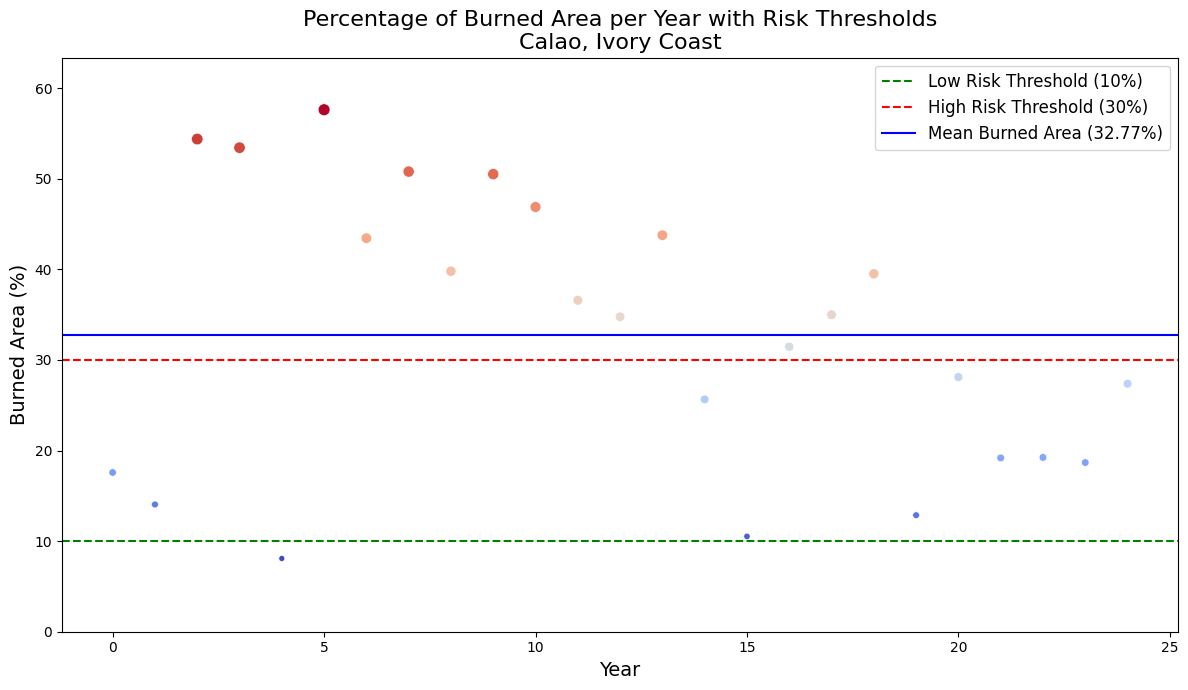

In [50]:
# Define risk thresholds
low_risk_threshold = 10  # Low risk threshold (10%)
high_risk_threshold = 30  # High risk threshold (30%)
mean_threshold = mean_area_percentage  # Mean burned area percentage

# Add a column for point size (optional, for visualization purposes)
df['point_size'] = df['burned_area_percentage'] * 10  # Scale size for better visualization

# Create the scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x='year',
    y='burned_area_percentage',
    size='point_size',
    hue='burned_area_percentage',
    palette='coolwarm',
    legend=False
)

# Add horizontal lines for risk thresholds
plt.axhline(y=low_risk_threshold, color='green', linestyle='--', label='Low Risk Threshold (10%)')
plt.axhline(y=high_risk_threshold, color='red', linestyle='--', label='High Risk Threshold (30%)')
plt.axhline(y=mean_threshold, color='blue', linestyle='-', label=f'Mean Burned Area ({mean_threshold:.2f}%)')

# Set labels and title
plt.title(f'Percentage of Burned Area per Year with Risk Thresholds\n{project_area_name}, {country}', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Burned Area (%)', fontsize=14)

# Set y-axis limits
plt.ylim(0, df['burned_area_percentage'].max() * 1.1)

# Show legend
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()